In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import json
import numpy as np

## Dataloader

In [43]:
clean_dir = '/home/tk/Documents/clean/' 
mix_dir = '/home/tk/Documents/mix/' 
clean_label_dir = '/home/tk/Documents/clean_labels/' 
mix_label_dir = '/home/tk/Documents/mix_labels/' 

cleanfolder = os.listdir(clean_dir)
cleanfolder.sort()

mixfolder = os.listdir(mix_dir)
mixfolder.sort()

cleanlabelfolder = os.listdir(clean_label_dir)
cleanlabelfolder.sort()

mixlabelfolder = os.listdir(mix_label_dir)
mixlabelfolder.sort()

clean_list = []
mix_list = []
clean_label_list = []
mix_label_list = []

In [46]:
class MSourceDataSet(Dataset):
    
    def __init__(self, clean_dir, mix_dir, clean_label_dir, mix_label_dir):
                

        for i in cleanfolder:
            with open(clean_dir + '{}'.format(i)) as f:
                clean_list.append(torch.Tensor(json.load(f)))

        for i in mixfolder:
            with open(mix_dir + '{}'.format(i)) as f:
                mix_list.append(torch.Tensor(json.load(f)))
                
        for i in cleanlabelfolder:
            with open(clean_label_dir + '{}'.format(i)) as f:
                clean_label_list.append(torch.Tensor(json.load(f)))

        for i in mixlabelfolder:
            with open(mix_label_dir + '{}'.format(i)) as f:
                mix_label_list.append(torch.Tensor(json.load(f)))
        
        cleanblock = torch.cat(clean_list, 0)
        mixblock = torch.cat(mix_list, 0)
        self.spec = torch.cat([cleanblock, mixblock], 0)
                
        cleanlabel = torch.cat(clean_label_list, 0)
        mixlabel = torch.cat(mix_label_list, 0)
        self.label = torch.cat([cleanlabel, mixlabel], 0)

        
    def __len__(self):
        return self.spec.shape[0]

                
    def __getitem__(self, index): 

        spec = self.spec[index]
        label = self.label[index]
        return spec, label

In [47]:
trainset = MSourceDataSet(clean_dir, mix_dir, clean_label_dir, mix_label_dir)

trainloader = torch.utils.data.DataLoader(dataset = trainset,
                                                batch_size = 4,
                                                shuffle = True)

# testloader = torch.utils.data.DataLoader(dataset = testset,
#                                                batch_size = 4,
#                                                shuffle = True)

In [ ]:
length = trainset.__len__()
print ("Trainset length =", length)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1025*16, 500, 3)
        self.fc1 = nn.Linear(1025*16, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)

        
    def forward(self, x):
        x = x.view(-1, 1025*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
    
model = Net()
print (model)

Net(
  (conv1): Conv2d(16400, 500, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=16400, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [15]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.003)

In [16]:
loss_record = []
every_loss = []
epoch_loss = []

model.train()
for epoch in range(500):
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        every_loss.append(loss.item())
        
        if i % 275 == 0:
            epoch_loss.append(np.mean(every_loss))
            every_loss = []
            print ('[%d, %5d] loss: %.3f' % (epoch, i, loss.item()))
            
torch.save(model, 'FeatureNet.pkl')

[0,     0] loss: 6.247
[1,     0] loss: 2.333


KeyboardInterrupt: 

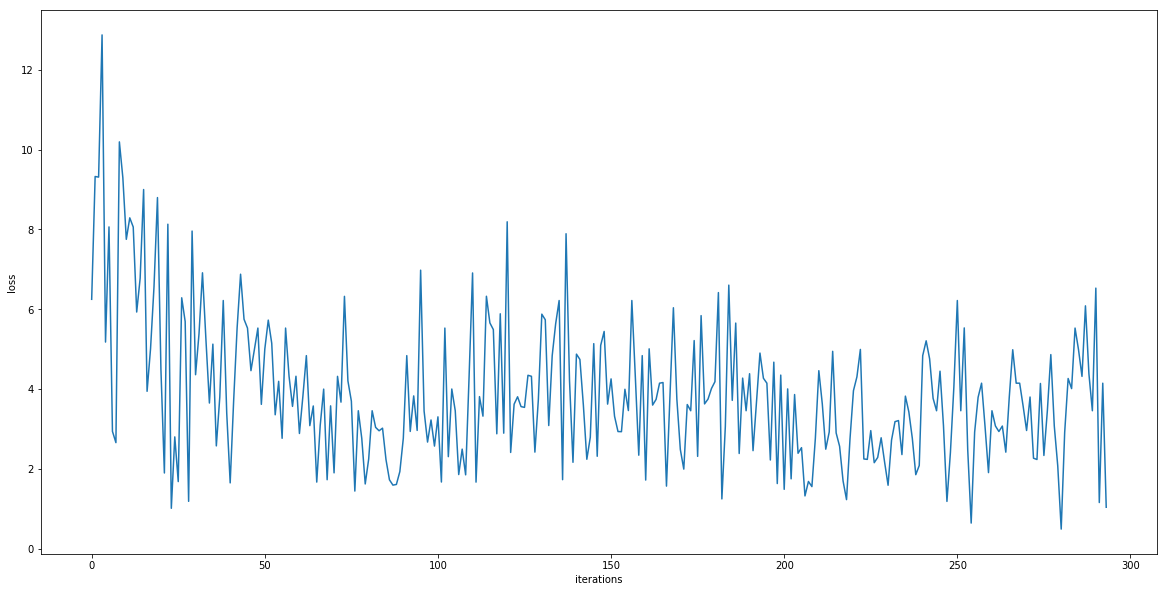

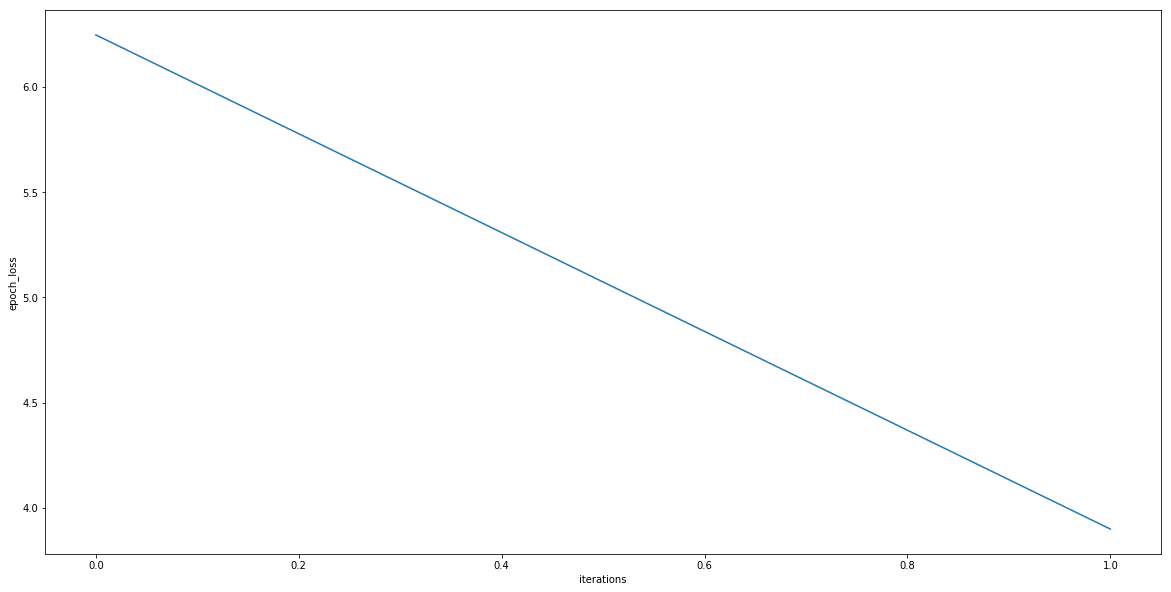

In [18]:
plt.figure(figsize = (20, 10))
plt.plot(loss_record)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(epoch_loss)
plt.xlabel('iterations')
plt.ylabel('epoch_loss')
plt.savefig('epoch_loss')
plt.show()